In [ ]:
import os
import random
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import welch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
# Add the folder to the system path
sys.path.append('/content/drive/MyDrive/EEG_f/')
# Now you can import the file
from read_eeg import get_eeg_info  # or import specific functions, e.g., from read_eeg import read_eeg

In [ ]:
def read_egg(path):
    mat = scipy.io.loadmat(path)
    eeg = mat['transferred_EEG']['trial'][0,0][0,0]  # first trial
    return eeg

In [ ]:
# --- Parameters ---
healthy_folder = '/content/drive/MyDrive/Data_EEG/Healthy/'
ad_folder = '/content/drive/MyDrive/Data_EEG/AD/'

fs = 500
min_samples = int(1.0 * 60 * fs)
max_samples = int(1.0 * 60 * fs)
num_segments = 50 # extract 50 segments from each sample!

# --- File Loading ---
ad_files = [f for f in os.listdir(ad_folder)]
healthy_files = [f for f in os.listdir(healthy_folder)]

random.seed(1)
random.shuffle(ad_files)
random.shuffle(healthy_files)

AD_data = {}
heal_data = {}

for i in ad_files:
    egg = read_egg(ad_folder + i)
    AD_data[i + '_AD'] = egg

for i in healthy_files:
    egg = read_egg(healthy_folder + i)
    heal_data[i+ '_healthy'] = egg

In [ ]:
def split_dict_with_sklearn(data_dict, seed=42):
    keys = list(data_dict.keys())

    # First: split into train (80%) and temp (20%)
    train_keys, temp_keys = train_test_split(keys, test_size=0.4, random_state=seed)

    # Second: split temp into val (10%) and test (10%)
    val_keys, test_keys = train_test_split(temp_keys, test_size=0.5, random_state=seed)

    # Reconstruct dictionaries
    train = {k: data_dict[k] for k in train_keys}
    val   = {k: data_dict[k] for k in val_keys}
    test  = {k: data_dict[k] for k in test_keys}
    return train, val, test

In [ ]:
# Apply to each class
ad_train, ad_val, ad_test = split_dict_with_sklearn(AD_data)
hl_train, hl_val, hl_test = split_dict_with_sklearn(heal_data)

# Combine class-wise splits
train_rd = {**ad_train, **hl_train}
val_rd   = {**ad_val, **hl_val}
test_rd  = {**ad_test, **hl_test}

print(f"Train size: {len(train_rd)}, Val: {len(val_rd)}, Test: {len(test_rd)}")

Train size: 19, Val: 6, Test: 7


In [ ]:
max_samples

30000

In [ ]:
def segment_subjects_non_overlapping(data_dict, segment_len):
    segments = []
    labels = []
    for k, eeg in data_dict.items():
        total_samples = eeg.shape[1]
        print(total_samples)
        num_segments = total_samples // segment_len  # Only full-length segments

        for i in range(num_segments):
            start = i * segment_len
            end = start + segment_len
            segment = eeg[:, start:end]
            segments.append(segment)
            labels.append(1 if '_AD' in k else 0)

    return segments, labels

In [ ]:
#bands = {'Delta': (1, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30), 'Gamma': (30, 70)}
def extract_features(eeg_data, fs):
    features = []
    for seg in eeg_data:
        feature = []
        for ch in seg:
            f, pxx = welch(ch, fs=fs, window='hamming', nperseg=512, noverlap=256, nfft=512) # sliding window that has size of 256 units.
            feature.append(np.array(pxx))
        features.append(np.array(feature))
    print(np.array(features).shape)
    return np.array(features)

In [ ]:
# --- Process Data ---
train_data, train_labels = segment_subjects_non_overlapping(train_rd, max_samples)
val_data, val_labels = segment_subjects_non_overlapping(val_rd, max_samples)
test_data, test_labels = segment_subjects_non_overlapping(test_rd, max_samples)

# Balance train set to make both ==
#train_data, train_labels = shuffle(train_data, train_labels, random_state=1)
#ad_idx = [i for i, l in enumerate(train_labels) if l == 1]
#hl_idx = [i for i, l in enumerate(train_labels) if l == 0]
#min_class = min(len(ad_idx), len(hl_idx))
#sel_idx = ad_idx[:min_class] + hl_idx[:min_class]
#train_data = [train_data[i] for i in sel_idx]
#train_labels = [train_labels[i] for i in sel_idx]

# Feature extraction
train_features = extract_features(train_data, fs)
val_features = extract_features(val_data, fs)
test_features = extract_features(test_data, fs)

210000
210000
210000
210000
210000
210000
210000
210000
210000
209500
210000
202500
210000
210000
210000
210000
210000
210000
210000
210000
215000
210000
210000
210000
210000
210000
210000
210000
210000
210000
210000
210000
(131, 19, 257)
(42, 19, 257)
(49, 19, 257)


In [ ]:
print(train_features.shape, val_features.shape, test_features.shape)

(131, 19, 257) (42, 19, 257) (49, 19, 257)


In [ ]:
print(len(train_labels), len(val_labels), len(test_labels))

131 42 49


In [ ]:
print(np.max(train_features))

328.81693


### Data Normalizaion

In [ ]:
def data_normalization(data):
    maxx = np.max(data)
    re = np.zeros((data.shape))
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            re[i, j, :] = data[i, j, :] / maxx
    return re

In [ ]:
train_features = data_normalization(train_features)
val_features = data_normalization(val_features)
test_features = data_normalization(test_features)

### ML pipeline

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, Dense, InputLayer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


In [ ]:
X_train = np.transpose(train_features, (0, 2, 1))
X_val   = np.transpose(val_features, (0, 2, 1))
X_test  = np.transpose(test_features, (0, 2, 1))

In [ ]:
y_train_cat = np.array(train_labels)
y_val_cat   = np.array(val_labels)
y_test_cat  = np.array(test_labels)

In [ ]:
X_test.shape

(49, 257, 19)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

model = Sequential([
    InputLayer(input_shape=(19, 257, 1)),  # height=19, width=257, 1 channel

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary output
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [32]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.h5',              # file to save the best model
    monitor='val_accuracy',       # monitor validation accuracy
    mode='max',                   # we want to maximize accuracy
    save_best_only=True,          # only save the best model
    verbose=1
)

# Compile your model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model with checkpoint callback
history = model.fit(X_train, y_train_cat,
                    validation_data=(X_val, y_val_cat),
                    epochs=500,
                    batch_size=32,
                    callbacks=[checkpoint],
                    verbose=1)


Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.8113 - loss: 0.5077
Epoch 1: val_accuracy improved from -inf to 0.78571, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 803ms/step - accuracy: 0.8110 - loss: 0.5075 - val_accuracy: 0.7857 - val_loss: 0.4184
Epoch 2/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7188 - loss: 0.5293
Epoch 2: val_accuracy did not improve from 0.78571
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7536 - loss: 0.4785 - val_accuracy: 0.7857 - val_loss: 0.4197
Epoch 3/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8125 - loss: 0.4112
Epoch 3: val_accuracy did not improve from 0.78571
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7835 - loss: 0.4264 - val_accuracy: 0.7857 - val_loss: 0.4094
Epoch 4/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6875 - loss: 0.5360
Epoch 4: val_accuracy did not improve from 0.78571
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7552 - loss: 0.4707 - val_accuracy: 0.7857 - val_loss: 0.4056
Epoch 5/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8125 - loss: 0.3451
Epoch 5: val_accuracy did not improve from 0.78571
5

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8242 - loss: 0.4083 - val_accuracy: 0.8095 - val_loss: 0.3989
Epoch 7/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8125 - loss: 0.3450
Epoch 7: val_accuracy did not improve from 0.80952
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7809 - loss: 0.4187 - val_accuracy: 0.8095 - val_loss: 0.3972
Epoch 8/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7500 - loss: 0.4370
Epoch 8: val_accuracy improved from 0.80952 to 0.83333, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8079 - loss: 0.3902 - val_accuracy: 0.8333 - val_loss: 0.3927
Epoch 9/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7812 - loss: 0.3754
Epoch 9: val_accuracy did not improve from 0.83333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8109 - loss: 0.3815 - val_accuracy: 0.8333 - val_loss: 0.3888
Epoch 10/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7812 - loss: 0.4795
Epoch 10: val_accuracy did not improve from 0.83333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7825 - loss: 0.4606 - val_accuracy: 0.8333 - val_loss: 0.3868
Epoch 11/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.7812 - loss: 0.3870
Epoch 11: val_accuracy did not improve from 0.83333
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8195 - loss: 0.4076 - val_accuracy: 0.8095 - val_loss: 0.3899
Epoch 12/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8750 - loss: 0.3654
Epoch 12: val_accuracy did not improve from 0.83

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8327 - loss: 0.3819 - val_accuracy: 0.8810 - val_loss: 0.3749
Epoch 15/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7812 - loss: 0.3723
Epoch 15: val_accuracy did not improve from 0.88095
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8036 - loss: 0.3670 - val_accuracy: 0.8571 - val_loss: 0.3755
Epoch 16/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7812 - loss: 0.4844
Epoch 16: val_accuracy did not improve from 0.88095
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8044 - loss: 0.4043 - val_accuracy: 0.8810 - val_loss: 0.3685
Epoch 17/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.8750 - loss: 0.4037
Epoch 17: val_accuracy did not improve from 0.88095
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8618 - loss: 0.3804 - val_accuracy: 0.8810 - val_loss: 0.3635
Epoch 18/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8750 - loss: 0.4245
Epoch 18: val_accuracy did not improve from 0.8

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8377 - loss: 0.3316 - val_accuracy: 0.9048 - val_loss: 0.3019
Epoch 48/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9688 - loss: 0.2077
Epoch 48: val_accuracy did not improve from 0.90476
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8573 - loss: 0.3170 - val_accuracy: 0.8810 - val_loss: 0.3092
Epoch 49/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.1384
Epoch 49: val_accuracy did not improve from 0.90476
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8995 - loss: 0.2954 - val_accuracy: 0.8810 - val_loss: 0.3299
Epoch 50/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8750 - loss: 0.2607
Epoch 50: val_accuracy did not improve from 0.90476
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8450 - loss: 0.3194 - val_accuracy: 0.8333 - val_loss: 0.3422
Epoch 51/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7188 - loss: 0.5083
Epoch 51: val_accuracy did not improve from 0.9

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8929 - loss: 0.2704 - val_accuracy: 0.9286 - val_loss: 0.2800
Epoch 87/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8125 - loss: 0.3417
Epoch 87: val_accuracy did not improve from 0.92857
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8689 - loss: 0.2945 - val_accuracy: 0.9286 - val_loss: 0.2817
Epoch 88/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8125 - loss: 0.3702
Epoch 88: val_accuracy did not improve from 0.92857
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8938 - loss: 0.3046 - val_accuracy: 0.8810 - val_loss: 0.2847
Epoch 89/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9375 - loss: 0.2318
Epoch 89: val_accuracy did not improve from 0.92857
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9127 - loss: 0.2446 - val_accuracy: 0.8810 - val_loss: 0.2931
Epoch 90/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9688 - loss: 0.1505
Epoch 90: val_accuracy did not improve from 0.92

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8854 - loss: 0.2936 - val_accuracy: 0.9524 - val_loss: 0.2674
Epoch 100/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7812 - loss: 0.4997
Epoch 100: val_accuracy did not improve from 0.95238
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8448 - loss: 0.3684 - val_accuracy: 0.9524 - val_loss: 0.2671
Epoch 101/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9375 - loss: 0.2404
Epoch 101: val_accuracy did not improve from 0.95238
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9285 - loss: 0.2643 - val_accuracy: 0.9524 - val_loss: 0.2671
Epoch 102/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8750 - loss: 0.2521
Epoch 102: val_accuracy did not improve from 0.95238
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8836 - loss: 0.2644 - val_accuracy: 0.9524 - val_loss: 0.2677
Epoch 103/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.8438 - loss: 0.3286
Epoch 103: val_accuracy did not improv

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9161 - loss: 0.2275 - val_accuracy: 0.9762 - val_loss: 0.1947
Epoch 183/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9062 - loss: 0.1996
Epoch 183: val_accuracy did not improve from 0.97619
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8949 - loss: 0.2335 - val_accuracy: 0.9762 - val_loss: 0.1931
Epoch 184/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9375 - loss: 0.2155
Epoch 184: val_accuracy did not improve from 0.97619
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9333 - loss: 0.2230 - val_accuracy: 0.9762 - val_loss: 0.1937
Epoch 185/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9062 - loss: 0.2375
Epoch 185: val_accuracy did not improve from 0.97619
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9263 - loss: 0.2196 - val_accuracy: 0.9524 - val_loss: 0.1964
Epoch 186/500
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 1.0000 - loss: 0.1510
Epoch 186: val_accuracy did not improve 

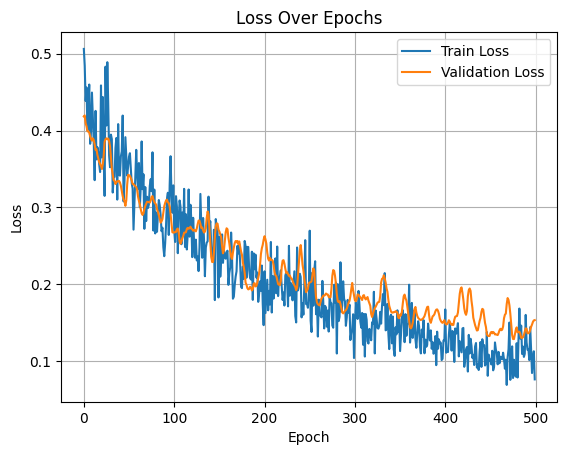

In [33]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
from tensorflow.keras.models import load_model

# Load the best model
#best_model = load_model('best_model.h5')

# Predict
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()

# Compute accuracy
accuracy = np.mean(y_pred_labels == y_test_cat)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step
Test Accuracy: 73.47%


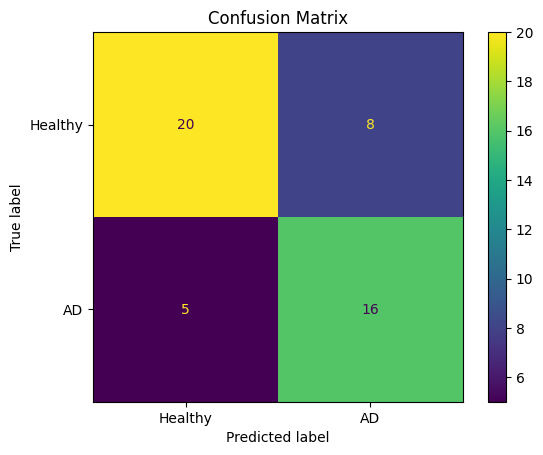

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test_cat, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'AD'])

# Plot
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()
